In [1]:
import numpy as np
import pandas as pd
import tqdm
import jax
import jax.numpy as jnp
import string
import tensorflow as tf
import time
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

# import libraries relevant to plotting (t-SNE)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Minimizing Objective Function for SGNS

$$

\min_{\theta} = \frac{1}{N} \sum_{i=1}^{N} [log \sigma(u_{ic}^T)  + \sum_{k=1}^{K}log \sigma(-u_{kc}^T v_{iw})]

\\
\\
\theta = [U, V]

$$

In [2]:
# sigmoid function
def sigmoid(x):
    """Inputs a real number, outputs a real number"""
    return 1 / (1 + jnp.exp(-x))


In [3]:
# define function to get embedding vectors
def get_embedding_vectors(target, context, V, U):
    """
    Input (example)
    target = (188,)
    context = (93, 40, 1648, 1659, 1109)
    V: matrix of dim (n x |v|)
    U: matrix of dim (|v| x n)
        n = embedding dimension, |v| = vocab size

    Output
    v_t: target word vector, dimension: (n,)
    u_c: context word vectors, consists of u_pos and u_neg: dimension: (n, len(context))
    """
    target = target.astype(int)
    context = context.astype(int)
    v_t = V.T[target]
    u_c = U[context]
    return v_t, u_c

# t = targets[0]
# c = contexts[0]
# v_test, u_test = get_embedding_vectors(t, c, V, U)
# print(f'v_test shape: {v_test.shape}')
# print(f'u_test shape: {u_test.shape}')

In [4]:
# define local_loss function
@jax.jit
def local_loss(params):
    """
    Input (example)
    params = [v_t, jnp.array([u_pos, u_neg])]
        v_t: target word vector, dimension: (n,)
        u_c: context word vectors, consists of u_pos and u_neg: dimension: (len(context), n)

    Output
    local_loss: real number
    """
    v_t = params[0]
    u_c = params[1]
    return -jnp.log(sigmoid(jnp.dot(u_c[0], v_t))) - jnp.sum(jnp.log(sigmoid(-jnp.dot(u_c[1:], v_t))))

# p = [V[:, 0], U[:5, :]]
# print(f'local_loss: {local_loss(p)}')


In [5]:
# define gradient function
L_grad = jax.grad(local_loss)

# g = L_grad([V[:, 0], U[:5, :]])
# print(f"g[0] shape: {g[0].shape}")
# print(f"g[1] shape: {g[1].shape}")

In [6]:
# function to evaluate the model performance over each epoch
# define a logistic function
# predicts if a (target word, context word) pair is a positive or negative sample
# takes as input a batch of target indices, batch of context indices, word embedding matrices V and U
def predict_proba(target, context, V):
    """
    Input
    target: vector of shape (batch_size,) --> target word indices
    context: vector of shape (batch_size,) --> context word indices
    V: matrix of shape (n, |v|) --> word embedding matrix

    Output
    predicted: vector of shape (batch_size,) --> predicted values
    """
    target = target.astype(int)
    context = context.astype(int)
    v_t = V.T[target] # dimensions: (batch_size, n)
    u_c = V.T[context] # dimensions: (batch_size, n)
    return sigmoid(np.sum(v_t * u_c, axis=1)) # dimensions: (batch_size,)

# define a predict function
# takes as input batch of target indices, batch of context indices, word embedding matrices V
# calculates the predicted values using the sigmoid function
# given a threshold of 0.5, predicts if a (target word, context word) pair is a positive or negative sample
def predict(target, context, V, threshold=0.5):
    """
    Input
    target: vector of shape (batch_size,) --> target word indices
    context: vector of shape (batch_size,) --> context word indices
    V: matrix of shape (n, |v|) --> word embedding matrix
    threshold: real number --> threshold value for the sigmoid function

    Output
    predicted: vector of shape (batch_size,) --> predicted values
    """
    target = target.astype(int)
    context = context.astype(int)
    v_t = V.T[target]
    u_c = V.T[context]
    return np.where(sigmoid(np.sum(v_t * u_c, axis=1)) > threshold, 1, 0)

# define a function that calculates the MSE between predicted and actual values
def mse(predicted, actual):
    """
    Input
    predicted: vector of shape (batch_size,) --> predicted values (probabilities summing to 1)
    actual: vector of shape (batch_size,) --> actual values

    Output
    mse: real number --> mean squared error
    """
    return np.mean((predicted - actual) ** 2)

def accuracy_score(predicted, actual):
    """
    Input
    predicted: vector of shape (batch_size,) --> predicted values (0 or 1)
    actual: vector of shape (batch_size,) --> actual values

    Output
    accuracy: real number --> accuracy score
    """
    return np.mean(predicted == actual)

In [7]:
def evaluate_model(V, targets, contexts, labels, num_samples=1000):
    """
    Input
    V: matrix of shape (n, |v|) --> word embedding matrix
    targets: matrix of shape (batch_size,) --> target word indices
    contexts: matrix of shape (batch_size,) --> context word indices
    labels: matrix of shape (batch_size,) --> actual values

    Output
    mse_score: real number --> mean squared error
    accuracy: real number --> accuracy score
    """
    # randomly select a batch of 1000 samples from the data, since for contexts and labels, we only take the first column
    indices = np.random.choice(len(targets), num_samples, replace=False)
    targets_random = targets[indices]
    if len(contexts.shape) > 1:
        contexts_random = contexts[indices, 0]
        labels_random = labels[indices, 0]
    elif len(contexts.shape) == 1:
        contexts_random = contexts[indices]
        labels_random = labels[indices]

    # calculate accuracy
    predicted_binary = predict(targets_random, contexts_random, V)
    accuracy = accuracy_score(predicted_binary, labels_random)

    # calculate mse
    predicted_proba = predict_proba(targets_random, contexts_random, V)
    mse_score = mse(predicted_proba, labels_random)

    return mse_score, accuracy
    

In [78]:
# read in the processed data

# read .npy files from data/processed_data/train
# train
targets_train = np.load('./data/processed_data/train/num_ns_20/targets.npy')
contexts_train = np.load('./data/processed_data/train/num_ns_20/contexts.npy')
lables_train = np.load('./data/processed_data/train/num_ns_20/labels.npy')

# test
targets_test = np.load('./data/processed_data/test/num_ns_20/targets.npy')
contexts_test = np.load('./data/processed_data/test/num_ns_20/contexts.npy')
lables_test = np.load('./data/processed_data/test/num_ns_20/labels.npy')

# read vocab and inverse vocab json files from data/processed_data
import json
with open('./data/processed_data/vocab.json') as f:
    vocab = json.load(f)

with open('./data/processed_data/inverse_vocab.json') as f:
    inverse_vocab = json.load(f)

# print shapes of all the variables
print(f"targets_train shape: {targets_train.shape}")
print(f"contexts_train shape: {contexts_train.shape}")
print(f"lables_train shape: {lables_train.shape}")

print(f"targets_test shape: {targets_test.shape}")
print(f"contexts_test shape: {contexts_test.shape}")
print(f"lables_test shape: {lables_test.shape}")

print(f"vocab length: {len(vocab)}")
print(f"inverse_vocab length: {len(inverse_vocab)}")

targets_train shape: (252240,)
contexts_train shape: (252240, 21)
lables_train shape: (252240, 21)
targets_test shape: (5202,)
contexts_test shape: (5202,)
lables_test shape: (5202,)
vocab length: 15900
inverse_vocab length: 15900


In [79]:
# set up
n = 300
v = len(vocab)
V_init = np.random.normal(0, 1, size=(n, v)) / np.sqrt(n)
U_init = np.random.normal(0, 1, size=(v, n)) / np.sqrt(n)

targets_data = targets_train.astype(float)
contexts_data = contexts_train.astype(float)
labels_data = lables_train.astype(float)

print(f'V shape: {V_init.shape}')
print(f'U shape: {U_init.shape}')
print(f'targets_data shape: {targets_data.shape}')
print(f'contexts_data shape: {contexts_data.shape}')
print(f'labels_data shape: {labels_data.shape}')

V shape: (300, 15900)
U shape: (15900, 300)
targets_data shape: (252240,)
contexts_data shape: (252240, 21)
labels_data shape: (252240, 21)


In [81]:
# train using (stochastic) gradient descent

# set up
V = V_init.copy()
U = U_init.copy()
params = [V, U]

N = len(targets_data)
n_epochs = 100

lr = 0.1

# results
epoch_losses = []
train_mses = []
train_accuracies = []
test_mses = []
test_accuracies = []

# gradient descent
for epoch in range(n_epochs):

    start_time = time.time()

    # shuffle data
    perm = np.random.permutation(N)
    targets_epoch = targets_data[perm]
    contexts_epoch = contexts_data[perm]
    labels_epoch = labels_data[perm]

    # every 20 epoch, lr -= 1
    if epoch == 50 and epoch == 75:
        lr /= 2

    losses = []
    for i in range(10000):
        # stop after 10000 iterations
        target = targets_epoch[i].astype(int) # ; print(f'target shape: {target.shape}')
        context = contexts_epoch[i].astype(int)# ; print(f'context shape: {context}')
        label = labels_epoch[i].astype(int)

        # get the embedding vectors
        v_t, u_c = get_embedding_vectors(target, context, V, U)

        # get the loss value and gradient
        loss_value = local_loss([v_t, u_c])
        grad = L_grad([v_t, u_c])

        # update the parameters
        partial_V = grad[0]
        partial_U = grad[1]
        
        V[:, target] = V[:, target] - lr * partial_V
        U[context, :] = U[context, :] - lr * partial_U

        # store the loss value
        losses.append(loss_value)
    

    # calculate train and test mse and accuracy for num_samples = 1000 random samples
    train_mse, train_accuracy = evaluate_model(V, targets_train, contexts_train, lables_train)
    test_mse, test_accuracy = evaluate_model(V, targets_test, contexts_test, lables_test)

    # store results
    epoch_losses.append(np.mean(losses))
    train_mses.append(train_mse)
    train_accuracies.append(train_accuracy)
    test_mses.append(test_mse)
    test_accuracies.append(test_accuracy)
    
    end_time = time.time()
    
    # print epoch loss
    if epoch % 1 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} \t loss = {np.mean(epoch_losses)} \t time = {end_time - start_time:.2f}s")

Epoch 1/100 	 loss = 10.731475830078125 	 time = 34.89s
Epoch 2/100 	 loss = 9.072687149047852 	 time = 37.40s
Epoch 3/100 	 loss = 8.226805686950684 	 time = 39.18s
Epoch 4/100 	 loss = 7.692913055419922 	 time = 35.81s
Epoch 5/100 	 loss = 7.387612342834473 	 time = 36.14s
Epoch 6/100 	 loss = 7.2051215171813965 	 time = 36.87s
Epoch 7/100 	 loss = 7.1611104011535645 	 time = 34.05s
Epoch 8/100 	 loss = 7.237549304962158 	 time = 34.76s
Epoch 9/100 	 loss = nan 	 time = 34.12s
Epoch 10/100 	 loss = nan 	 time = 33.97s
Epoch 11/100 	 loss = nan 	 time = 39.22s
Epoch 12/100 	 loss = nan 	 time = 35.91s


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

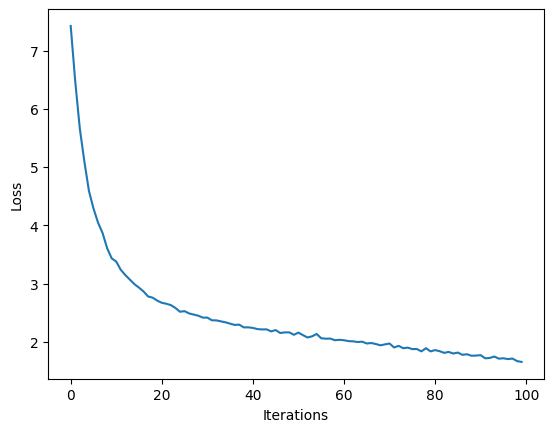

In [ ]:
# plot losses
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')

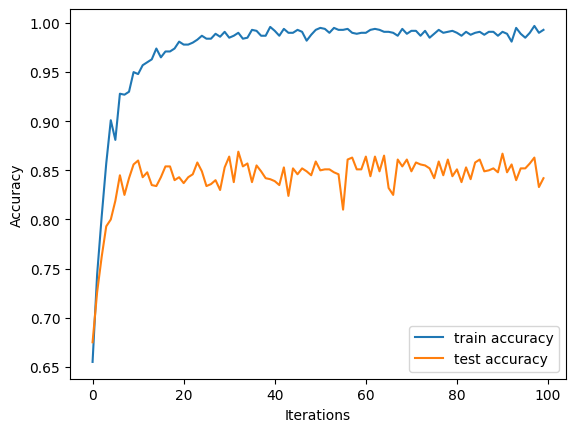

In [ ]:
# plot training accuracy and test accuracy on the same plot
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

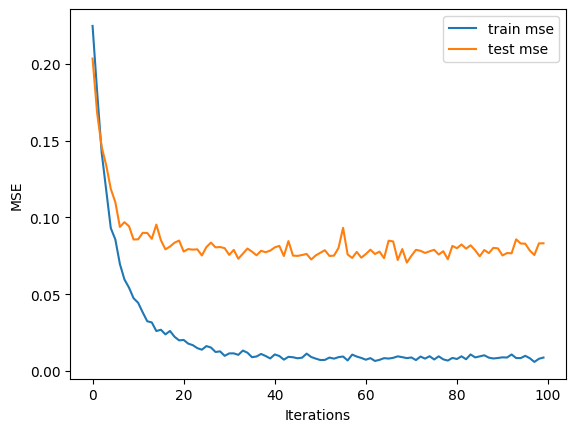

In [ ]:
# plot training and test mse on the same plot
plt.plot(train_mses, label='train mse')
plt.plot(test_mses, label='test mse')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()

In [ ]:
# copy U and V
V_trained = np.copy(params[0])
U_trained = np.copy(params[1])

print(f'V_trained shape: {V_trained.shape}')
print(f'U_trained shape: {U_trained.shape}')

V_trained shape: (300, 15900)
U_trained shape: (15900, 300)


#### Results

| Model Used | Num samples used | Num of Neg Samples | Train Accuracy | Test Accuracy | Train MSE | Test MSE |
|:-----------|:-----------------|:-------------------|:---------------|:--------------|:----------|:---------|
| Case 1 | 1M - 100 epochs, 10,000 it/ep | 5 | 0.9795 | 0.8220 | 0.0221 | 0.0948 |
| Case 2 | 1M - 100 epochs, 10,000 it/ep | 10 | 0.9877 | 0.8604 | 0.014 | 0.0817 |
| Case 3 | 1M - 100 epochs, 10,000 it/ep | 20 | 0.9895 | 0.8627 | 0.0064 | 0.0731 |
| Case 4 | 1M - 100 epochs, 5,000 it/ep | 5 | 0.9867 | 0.8681 | 0.0253 | 0.0847 |
| Case 5 | 1M - 100 epochs, 5,000 it/ep | 10 | 0.9900 | 0.8439 | 0.0087 | 0.0811 |
| Case 6 | 1M - 100 epochs, 5,000 it/ep | 20 | 0.9892 | 0.8554 | 0.0057 | 0.0727 |

In [ ]:
# evaluate the final model
# train accuracy and mse
train_mse, train_accuracy = evaluate_model(V_trained, targets_train, contexts_train, lables_train, num_samples=len(targets_train))
print(f'train mse: {train_mse:.4f}')
print(f'train accuracy: {train_accuracy:.4f}')

# test accuracy and mse
test_mse, test_accuracy = evaluate_model(V_trained, targets_test, contexts_test, lables_test, num_samples=len(targets_test))
print(f'test mse: {test_mse:.4f}')
print(f'test accuracy: {test_accuracy:.4f}')

train mse: 0.0087
train accuracy: 0.9900
test mse: 0.0811
test accuracy: 0.8439


In [ ]:
# given epoch_losses, train_mses, train_accuracies, test_mses, test_accuracies
# convert them to 1 dataframe, with columns: epoch, epoch_losses, train_mses, train_accuracies, test_mses, test_accuracies
x = np.arange(n_epochs)
results = {'epoch': x, 'epoch_losses': epoch_losses, 'train_mses': train_mses, 'train_accuracies': train_accuracies, 'test_mses': test_mses, 'test_accuracies': test_accuracies}

In [77]:
# save all the results
# save V_trained, U_trained as csv files
np.savetxt('./results/sgns-partial/case5/V_trained.csv', V_trained, delimiter=',')
np.savetxt('./results/sgns-partial/case5/U_trained.csv', U_trained, delimiter=',')

# save results as csv file
results_df = pd.DataFrame(results)
results_df.to_csv('./results/sgns-partial/case5/results.csv', index=False)
results_df.head()

,epoch,epoch_losses,train_mses,train_accuracies,test_mses,test_accuracies
0,0,7.422009,0.224721,0.655,0.20348445,0.675
1,1,6.466398,0.18182316,0.744,0.16807655,0.726
2,2,5.660881,0.14217702,0.803,0.1459006,0.762
3,3,5.095473,0.11758743,0.857,0.13387053,0.793
4,4,4.592742,0.09304506,0.901,0.11860385,0.800
